# 1 picture：

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image as Image

import scipy
import scipy.misc
import scipy.cluster



def quantizetopalette(silf, palette, dither=False):
    """Convert an RGB or L mode image to use a given P image's palette."""
    # refs:
    # [1] https://stackoverflow.com/questions/29433243/convert-image-to-specific-palette-using-pil-without-dithering

    silf.load()

    # use palette from reference image
    palette.load()
    if palette.mode != "P":
        raise ValueError("bad mode for palette image")
    if silf.mode != "RGB" and silf.mode != "L":
        raise ValueError(
            "only RGB or L mode images can be quantized to a palette"
            )
    im = silf.im.convert("P", 1 if dither else 0, palette.im)
    # the 0 above means turn OFF dithering

    # Later versions of Pillow (4.x) rename _makeself to _new
    try:
        return silf._new(im)
    except AttributeError:
        return silf._makeself(im)


def convert_image(image, ncolors = 8):
    # refs:
    # [1]: https://stackoverflow.com/questions/3241929/python-find-dominant-most-common-color-in-an-image
    image = image.convert('RGB') # can't use alpha channel
    NUM_CLUSTERS = ncolors # unnecessary re-naming
    
    ar = np.array(image) # to data
    
    shape = ar.shape
    ar = ar.reshape(np.product(shape[:2]), shape[2]).astype(float)

    print('finding ' + str(ncolors) + ' most common colors.  Note, if "ncolors" is large, this can take a while...')
    codes, dist = scipy.cluster.vq.kmeans(ar, NUM_CLUSTERS)
    print('Done finding colors! cluster centres in RGB:\n', codes)

    vecs, dist = scipy.cluster.vq.vq(ar, codes)         # assign codes
    counts, bins = np.histogram(vecs, len(codes))    # count occurrences
    
    # into a 256 palette, integer types
    reds = np.round(np.interp(np.linspace(0,255,256), np.linspace(0,NUM_CLUSTERS-1,NUM_CLUSTERS), codes[:,0])).astype('int')
    greens = np.round(np.interp(np.linspace(0,255,256), np.linspace(0,NUM_CLUSTERS-1,NUM_CLUSTERS), codes[:,1])).astype('int')
    blues = np.round(np.interp(np.linspace(0,255,256), np.linspace(0,NUM_CLUSTERS-1,NUM_CLUSTERS), codes[:,2])).astype('int')

    # palette formatting:
    myPalette = []
    for i in range(256):
        myPalette.extend( (reds[i],greens[i],blues[i]))
        
    palimage = Image.new('P', (16, 16)) # placeholder image
    palimage.putpalette(myPalette)
    newimage = quantizetopalette(image, palimage, dither=False)
    newimage = newimage.convert('RGB')
    return newimage, codes

# similar to above, but allows you to import your own RGB sequence
def convert_image_specific(image, colors = [ [255, 255, 255], [255, 0, 0], [0,0,255], [0, 0, 0] ]):
    image = image.convert('RGB') # can't use alpha channel
    NUM_CLUSTERS = len(colors) # unnecessary re-naming
    codes = np.array(colors) # unnecessary renaming
    
    # into a 256 palette, integer types
    reds = np.round(np.interp(np.linspace(0,255,256), np.linspace(0,NUM_CLUSTERS-1,NUM_CLUSTERS), codes[:,0])).astype('int')
    greens = np.round(np.interp(np.linspace(0,255,256), np.linspace(0,NUM_CLUSTERS-1,NUM_CLUSTERS), codes[:,1])).astype('int')
    blues = np.round(np.interp(np.linspace(0,255,256), np.linspace(0,NUM_CLUSTERS-1,NUM_CLUSTERS), codes[:,2])).astype('int')

    # palette formatting:
    myPalette = []
    for i in range(256):
        myPalette.extend( (reds[i],greens[i],blues[i]))
        
    palimage = Image.new('P', (16, 16)) # placeholder image
    palimage.putpalette(myPalette)
    newimage = quantizetopalette(image, palimage, dither=False)
    newimage = newimage.convert('RGB')
    return newimage, codes

Specify the directory path to your image:

In [4]:
path_to_image = "/Users/zoe/Documents/590/rickmorty.jpg"

Read in image:

In [27]:
im= Image.open(path_to_image)

Take a quick look:

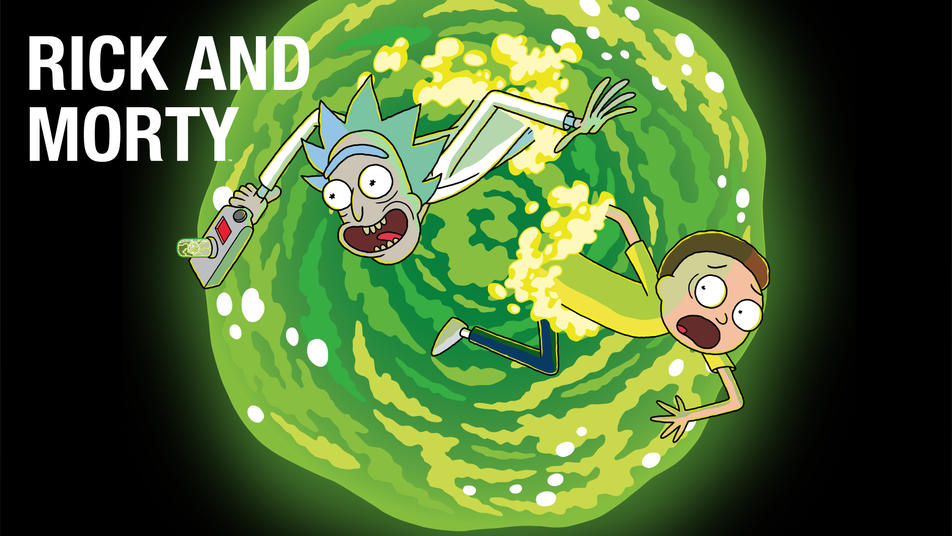

In [28]:
im

Convert to an 8-color image for easier handling:

In [7]:
new_im, new_rgbs = convert_image(im, ncolors = 8)

finding 8 most common colors.  Note, if "ncolors" is large, this can take a while...
Done finding colors! cluster centres in RGB:
 [[186.52902652 200.31638098 170.80623383]
 [251.68024216 250.57248791 231.17579585]
 [ 52.86604871 147.23789834  62.85965709]
 [  1.25663222   1.67757661   0.92870167]
 [ 19.14150619  32.15911125  13.44859641]
 [206.9959354  218.02002194  67.10785178]
 [ 49.2699176   77.3799158   33.09010555]
 [120.40676228 181.14656088  64.25540433]]


Take a quick look:

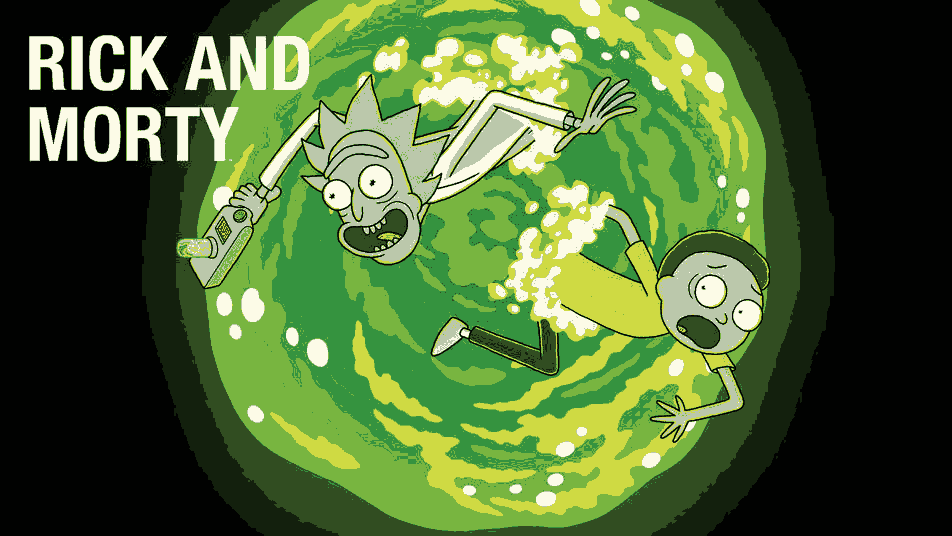

In [8]:
new_im

We can check that our conversion worked by printing out the unique colors in our new image (note the change to integer values here, as expected by an RGB color map):

In [29]:
im_data = np.array(new_im)
np.unique(im_data.reshape(-1, im_data.shape[2]), axis=0)

array([[  1,   2,   1],
       [ 19,  32,  13],
       [ 49,  77,  33],
       [ 53, 147,  63],
       [120, 181,  64],
       [187, 200, 171],
       [207, 218,  67],
       [252, 251, 231]], dtype=uint8)

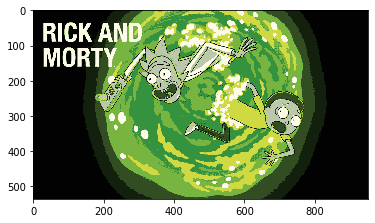

In [30]:
fig, ax = plt.subplots(figsize=(6,6)) 
ax.imshow(im_data) 
plt.show()

In [31]:
number_of_pixels_of_a_color = []
color_labels = []
colors = []
for icolor,rgba in enumerate(np.unique(im_data.reshape(-1, im_data.shape[2]), axis=0)):
    #print(icolor, rgba)
    
    # mask each channel
    reds_mask = im_data[:,:,0] == rgba[0]
    greens_mask = im_data[:,:,1] == rgba[1]
    blues_mask = im_data[:,:,2] == rgba[2]

    # combined mask
    pixel_mask = reds_mask & greens_mask & blues_mask
    
    # grab number of pixels
    this_color_pixels = im_data[pixel_mask]
    number_of_pixels_of_a_color.append(len(this_color_pixels))
    # this could be done better...
    color_labels.append( 'Color #' + str(icolor) )
    
    colors.append( rgba/255 )

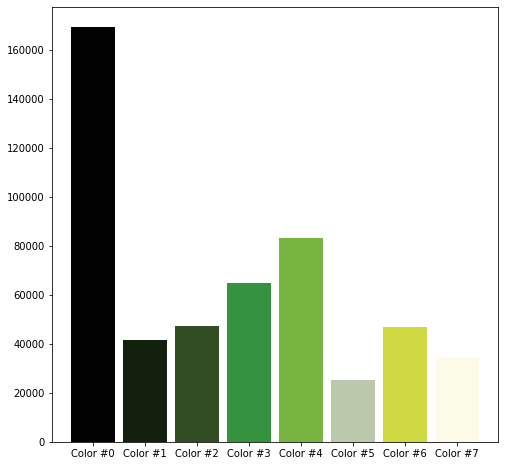

In [33]:
fig, ax = plt.subplots(figsize=(8,8))

myBarChart = ax.bar(color_labels, number_of_pixels_of_a_color) 
# set colors for each bar individually
for i in range(len(myBarChart)):
    myBarChart[i].set_color(colors[i])
    myBarChart[i].set_linewidth(2) # so we can see the outlines clearly

plt.show()

# 2 picture：

In [37]:
path_to_image = "/Users/zoe/Documents/590/gf.jpg"

finding 8 most common colors.  Note, if "ncolors" is large, this can take a while...
Done finding colors! cluster centres in RGB:
 [[170.85302475 192.03004923  17.01022566]
 [252.37223578 207.38477914 177.33477088]
 [ 15.44060955  18.10129144   6.47010068]
 [253.83328764 254.15900803 253.91076961]
 [175.5854142  106.92302446 177.18643266]
 [200.65422416 249.8733501   83.14801876]
 [ 57.19008297  62.86275855  31.81702915]
 [129.25571945  86.05781732  36.1159954 ]]


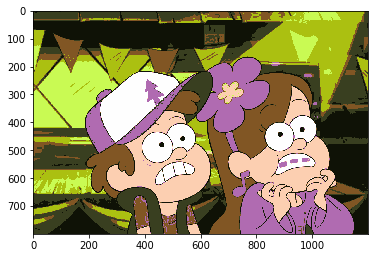

In [39]:
im2= Image.open(path_to_image)
new_im2, new_rgbs2 = convert_image(im2, ncolors = 8)
im_data2 = np.array(new_im2)
np.unique(im_data2.reshape(-1, im_data2.shape[2]), axis=0)
fig, ax = plt.subplots(figsize=(6,6)) 
ax.imshow(im_data2) 
plt.show()

In [42]:

number_of_pixels_of_a_color = []
color_labels = []
colors = []
for icolor,rgba in enumerate(np.unique(im_data2.reshape(-1, im_data2.shape[2]), axis=0)):
    #print(icolor, rgba)
    
    # mask each channel
    reds_mask = im_data2[:,:,0] == rgba[0]
    greens_mask = im_data2[:,:,1] == rgba[1]
    blues_mask = im_data2[:,:,2] == rgba[2]

    # combined mask
    pixel_mask = reds_mask & greens_mask & blues_mask
    
    # grab number of pixels
    this_color_pixels = im_data2[pixel_mask]
    number_of_pixels_of_a_color.append(len(this_color_pixels))
    # this could be done better...
    color_labels.append( 'Color #' + str(icolor) )
    
    colors.append( rgba/255 )

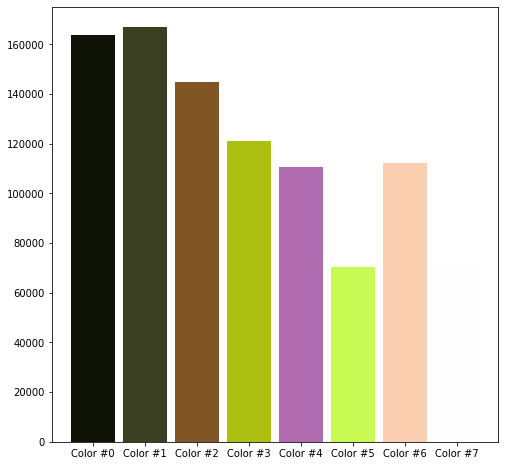

In [43]:
fig, ax = plt.subplots(figsize=(8,8))

myBarChart = ax.bar(color_labels, number_of_pixels_of_a_color) 
# set colors for each bar individually
for i in range(len(myBarChart)):
    myBarChart[i].set_color(colors[i])
    myBarChart[i].set_linewidth(2) # so we can see the outlines clearly

plt.show()

# 3 picture：

finding 8 most common colors.  Note, if "ncolors" is large, this can take a while...
Done finding colors! cluster centres in RGB:
 [[109.47885325 113.07137898  72.94800105]
 [ 91.04699159  54.16794978  41.84655928]
 [250.08709397 148.54903975 219.68825575]
 [189.32617057 191.65964404 194.06230049]
 [243.00231909 118.60360747  74.6027056 ]
 [165.91989845 150.84361376 135.48992384]
 [ 17.57518049  13.99070085  14.27641938]
 [240.0098497  232.6103328  239.36999463]]


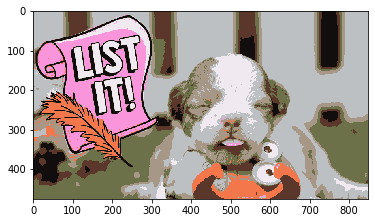

In [44]:
path_to_image = "/Users/zoe/Documents/590/dog.jpg"
im3= Image.open(path_to_image)
new_im3, new_rgbs3 = convert_image(im3, ncolors = 8)
im_data3= np.array(new_im3)
np.unique(im_data3.reshape(-1, im_data3.shape[2]), axis=0)
fig, ax = plt.subplots(figsize=(6,6)) 
ax.imshow(im_data3) 
plt.show()

In [49]:
number_of_pixels_of_a_color = []
color_labels = []
colors = []
for icolor,rgba in enumerate(np.unique(im_data3.reshape(-1, im_data3.shape[2]), axis=0)):
    #print(icolor, rgba)
    
    # mask each channel
    reds_mask = im_data3[:,:,0] == rgba[0]
    greens_mask = im_data3[:,:,1] == rgba[1]
    blues_mask = im_data3[:,:,2] == rgba[2]

    # combined mask
    pixel_mask = reds_mask & greens_mask & blues_mask
    
    # grab number of pixels
    this_color_pixels = im_data3[pixel_mask]
    number_of_pixels_of_a_color.append(len(this_color_pixels))
    # this could be done better...
    color_labels.append( 'Color #' + str(icolor) )
    
    colors.append( rgba/255 )



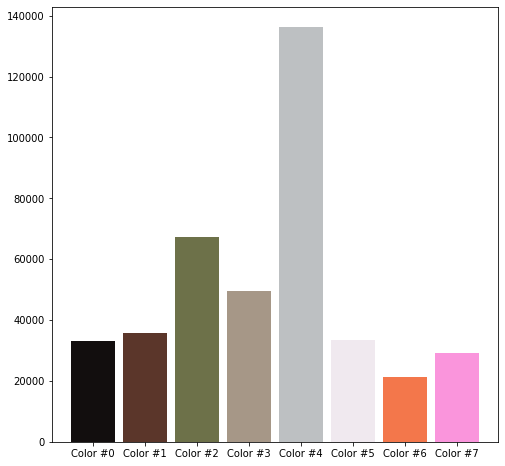

In [50]:
fig, ax = plt.subplots(figsize=(8,8))

myBarChart = ax.bar(color_labels, number_of_pixels_of_a_color) 
# set colors for each bar individually
for i in range(len(myBarChart)):
    myBarChart[i].set_color(colors[i])
    myBarChart[i].set_linewidth(2) # so we can see the outlines clearly

plt.show()

Write up：


I choose two kinds of pictures. First picture and second picture are both cartoon pictures while the third one is a photo. When transforming the photo, I find that after transforming, the photo's degree of distortion is reduced. My pictires dont "alpha" channel so they dont nedd  "alpha" mask here. 



What are some issues you can think of in how color is rebinned from a full color image into an image with less colors with the functions provided?


Transforming colors into image with less colors may distorting the real picture.




